In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

import data_cleaning

# Summary

This is an analysis originated from a bounty from [DiamondDAO](https://docs.diamonddao.xyz/welcome/values) that aims to analyze the data coming form ETH Denver attendees and their pathway in crypto after the event.

**Main objective:** 
- To determine the profile of inviduals attending the event.
- To understand the impacts of the event in the ecosystem. 

# Data loading / cleaning

## Loading..

In [2]:
#POAP data
poap = data_cleaning.get_cleaned_poap_data()

#DAOHaus data
dh_members, dh_votes, dh_proposals = data_cleaning.get_daohaus_cleaned_data()

#Snapshot data
snap_proposals, snap_votes = data_cleaning.get_snapshot_cleaned_data()

#Token balance data
spork, bufficorns = data_cleaning.get_token_holder_cleaned_data()

## Making adjustments and merges..

#### Creating identifier columns

In [5]:
# ETH Denver check
poap['is_ETHDenver_event'] = False
poap.loc[(poap.event_name.str.contains('ethdenver', case=False)) 
         | (poap.event_name.str.contains('eth denver', case=False)), 'is_ETHDenver_event'] = True


# Checking if it's an ethereum event (will not be 100% right here, but checking output I would assume this is good enough)
poap['is_ethereum_related_event'] = False
poap.loc[(poap.event_name.str.contains('eth',case=False)) |
              (poap.event_name.str.contains('ethereum', case=False)), 'is_ethereum_related_event'] = True

#marking all ETHDenver POAP holder
eth_denver_poap_holders = poap.loc[poap.is_ETHDenver_event==True, 'owner_id_checksum'].unique()
poap['has_ETH_Denver_POAP'] = False
poap.loc[poap.owner_id_checksum.isin(eth_denver_poap_holders), 'has_ETH_Denver_POAP'] = True

#### Merging SPORK holders data on POAP data

In [6]:
spork = spork.rename(columns={'holder_address': 'spork_holder_address', 
                              'balance':'spork_balance', 
                              'normalized_balance': 'spork_normalized_balance'})

poap = poap.merge(spork, left_on='owner_id_checksum', right_on='spork_holder_address', how='left')

#marking ETH Denver attendees after adding SPORK data
poap['is_ETH_Denver_participant'] = False
poap.loc[(poap.has_ETH_Denver_POAP==True) | (poap.is_spork_holder==True), 'is_ETH_Denver_participant'] = True

In [8]:
poap['is_spork_holder'] = False
poap.loc[poap.spork_holder_address.notnull(), 'is_spork_holder'] = True

sphold = poap.groupby(['has_ETH_Denver_POAP', 'is_spork_holder']).agg(attendee_count=('owner_id', 'nunique'))
sphold['%'] = (sphold['attendee_count'] / sphold.groupby(level=0).transform('sum')['attendee_count']) * 100

sphold

attendee_count          %
has_ETH_Denver_POAP is_spork_holder                           
False               False                    682422  99.858353
                    True                        968   0.141647
True                False                       746  71.730769
                    True                        294  28.269231

**Comment**: There is a considerable amount of spork holder that do not have have ETH Denver POAP.

#### Creating new dataset to have all POAP holder, SPORK holders and Bufficorn minters

In [16]:
ethd = poap.loc[poap.has_ETH_Denver_POAP==True, ['owner_id_checksum', 'has_ETH_Denver_POAP']].copy().drop_duplicates('owner_id_checksum')
ethd = ethd.rename(columns={'owner_id_checksum': 'address'})

spork_v2 = spork.rename(columns={'spork_holder_address': 'address'})
bufficorns_v2 = bufficorns.rename(columns={'bufficorn_minter_address': 'address'})
bufficorns_v2 = bufficorns_v2.drop_duplicates('address')

ethd = ethd.merge(spork_v2, on='address', how='outer')
ethd = ethd.merge(bufficorns_v2, on='address', how='outer')

In [17]:
ethd['profile_type'] = ''

ethd.loc[(ethd.has_ETH_Denver_POAP.notnull()) &
        (ethd.spork_balance.isnull())
         & (ethd.bufficorn_token_id.isnull()), 'profile_type'] = 'poap_holder_only'

ethd.loc[(ethd.has_ETH_Denver_POAP.isnull()) &
        (ethd.spork_balance.notnull())
         & (ethd.bufficorn_token_id.isnull()), 'profile_type'] = 'spork_holder_only'

ethd.loc[(ethd.has_ETH_Denver_POAP.isnull()) &
        (ethd.spork_balance.isnull())
         & (ethd.bufficorn_token_id.notnull()), 'profile_type'] = 'bufficorn_holder_only'

ethd.loc[(ethd.has_ETH_Denver_POAP.notnull()) &
        (ethd.spork_balance.notnull())
         & (ethd.bufficorn_token_id.isnull()), 'profile_type'] = 'poap_and_spork_holder'

ethd.loc[(ethd.has_ETH_Denver_POAP.notnull()) &
        (ethd.spork_balance.isnull())
         & (ethd.bufficorn_token_id.notnull()), 'profile_type'] = 'poap_and_bufficorn_holder'

ethd.loc[(ethd.has_ETH_Denver_POAP.isnull()) &
        (ethd.spork_balance.notnull())
         & (ethd.bufficorn_token_id.notnull()), 'profile_type'] = 'spork_and_bufficorn_holder'

ethd.loc[(ethd.has_ETH_Denver_POAP.notnull()) &
        (ethd.spork_balance.notnull())
         & (ethd.bufficorn_token_id.notnull()), 'profile_type'] = 'poap_spork_and_bufficorn_holder'

ethd.groupby('profile_type').agg(wallet_count=('address', 'nunique'))

,wallet_count
profile_type,
bufficorn_holder_only,797
poap_and_bufficorn_holder,15
poap_and_spork_holder,184
poap_holder_only,731
poap_spork_and_bufficorn_holder,110
spork_and_bufficorn_holder,627
spork_holder_only,1236


# Analysis

## - ETH Denver POAP profile

### Evolution of unique wallets and mints

##### Table #### 

   event_year  n_unique_wallets  total_tokens_minted
0        2018                27                   27
1        2019                84                   87
2        2020               243                  274
3        2021               740                 5066
4        2022                 9                    9


################ 


Number of unique minter addresses per year & total numbers of tokens minted (for ALL ETH Denver related POAPs)


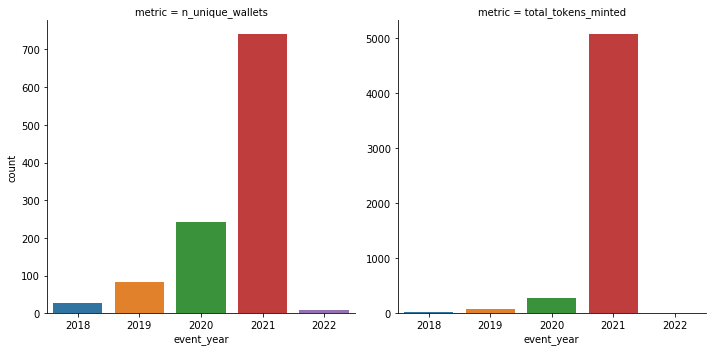

In [34]:
mints = poap.loc[(poap.has_ETH_Denver_POAP==True) & (poap.is_ETHDenver_event==True)]

mints_year = mints.groupby('event_year').agg(n_unique_wallets=('owner_id', 'nunique'), 
                                             total_tokens_minted=('token_id', 'nunique')).reset_index()

mints_melt = pd.melt(mints_year, id_vars=['event_year'], value_vars=['n_unique_wallets', 'total_tokens_minted'], 
                                                         var_name='metric', value_name='count')

print('##### Table #### \n')
print(mints_year)
print('\n')
print('################ \n\n')

print('Number of unique minter addresses per year & total numbers of tokens minted (for ALL ETH Denver related POAPs)')
sns.catplot(data=mints_melt, x='event_year', y='count', col='metric', kind='bar', sharey=False)

plt.show()

**Comment**: The numbers of unique minter addresses in consistently increasing, and it seems 2021 was a huge leap. This is also reflected in the total amount of tokens minted, where this effect in even drastic.

### Rentention (by the lens of POAP minting)

In [35]:
# count of users with X amount of years
lominters = mints.groupby('owner_id').agg(n_years_minted=('event_year', 'nunique')).reset_index()
lominters_group = lominters.groupby('n_years_minted').agg(unique_wallet_count=('owner_id', 'nunique'))
lominters_group['%'] = (lominters_group['unique_wallet_count'] / lominters_group['unique_wallet_count'].sum()) * 100

lominters_group

,unique_wallet_count,%
n_years_minted,,
1,985,94.711538
2,49,4.711538
3,4,0.384615
4,2,0.192308


**Comment:** Kind of makes sense once most people started gong on 2021. What about this % but considering when people started? 

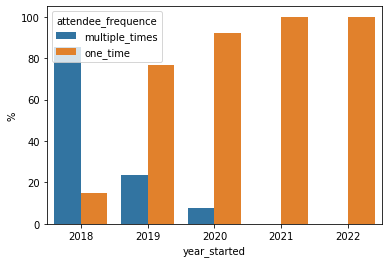

In [43]:
# count of users with X amount of years
lominters = mints.groupby(['owner_id']).agg(n_years_minted=('event_year', 'nunique'), 
                                            year_started=('event_year', 'min')).reset_index()
lominters['attendee_frequence'] = np.where(lominters['n_years_minted']>1, 'multiple_times', 'one_time')
lominters_group = lominters.groupby(['year_started','attendee_frequence']).agg(unique_wallet_count=('owner_id', 'nunique'))
lominters_group['%'] = (lominters_group['unique_wallet_count'] / lominters_group.groupby(level=0).transform('sum')['unique_wallet_count']) * 100

sns.barplot(data=lominters_group.reset_index(), x='year_started', y='%', hue='attendee_frequence')


**Comment**: We could say that the turnover rate here (% of people that just go to the event one time) seems to be increasing over time. This could be very much related to the increasing number of people coming to these events as the years pass by. Because there are relativelt few years of event yet, it remaisn to be seen how the newer cohorts of entrants will stick to the event. 

Limitations of this specific table: 
- As the number of attendes increase, we can have more one-time enthusiats that are only going due to crypto price action / curiosity.
- A LOT of attendees might not redeem their POAPs at all or maybe redeem POAPs in different wallets, which might led to this number increasing.
- As we get closer to recent years, the fewer chances "newer" people have to attend to new events (so with time retention might go up for recent years with time)

## - Event participation profile (ETH Denver attendees)

In [113]:
# here I am using POAP minting + spork token holding to mark people as ETH Denver participant
etha = poap.loc[(poap.is_ETH_Denver_participant==True) & (etha.is_ETHDenver_event==False)].copy()

### Aside from ETH Denver, what other types of events are these people going?

#### - Virtual vs IRL

In [114]:
virl = etha.groupby('virtual_event').agg(number_of_events=('event_name', 'nunique'))
virl['%'] = (virl['number_of_events'] / virl['number_of_events'].sum()) * 100
virl

,number_of_events,%
virtual_event,,
False,272,43.870968
True,348,56.129032


**Comment**:Most of the events attended by this people are online.

#### - Ethereum vs Non Ethereum events

In [115]:
virl = etha.groupby('is_ethereum_related_event').agg(number_of_events=('event_name', 'nunique'))
virl['%'] = (virl['number_of_events'] / virl['number_of_events'].sum()) * 100
virl

,number_of_events,%
is_ethereum_related_event,,
False,444,71.612903
True,176,28.387097


**Comment**: A lot of these events are not ethereum related too (although is hard to assess just from the name of the event so.. might be far from accurate here)

#### - Event country

In [116]:
virl = etha.groupby('event_country').agg(number_of_events=('event_name', 'nunique'))
virl['%'] = (virl['number_of_events'] / virl['number_of_events'].sum()) * 100
virl.sort_values('%', ascending=False).head(10)

,number_of_events,%
event_country,,
,370,59.677419
Argentina,34,5.483871
United States,25,4.032258
Ethereum,23,3.709677
Malaysia,20,3.225806
USA,19,3.064516
France,14,2.258065
Germany,13,2.096774
Canada,9,1.451613


**Comment**: Hard to assess too once the names of the countries don't have a standard and also big part of the entries don't have this field filled. 

#### - Most popular events among participants

In [117]:
#filtering out ETH Denver
evrank = etha.groupby(['event_name', 'is_ethereum_related_event'])\
                .agg(attendee_count=('owner_id', 'nunique'))\
                .sort_values('attendee_count', ascending=False)
evrank['%_total_participants'] = (evrank['attendee_count'] / len(poap.loc[poap.is_ETH_Denver_participant==True, 'owner_id'].unique()))

evrank.head(10)

,,attendee_count,%_total_participants
event_name,is_ethereum_related_event,,
The One Millionth POAP POAP,False,165,0.082171
Attendee - ETHDenver 2020,True,99,0.049303
Devcon5,False,91,0.045319
ETHDenver,True,87,0.043327
Staked - ETHDenver 2020,True,73,0.036355
ETHNewYork,True,73,0.036355
Metamask 10 Million Users Party,False,56,0.027888
DevCon4,False,49,0.024402
Stakeholder - ETHDenver 2020,True,45,0.022410


**Comment**: It seems from the names that the most popuplar events are either builder-type events or ethereum related.

### Does a ETH Denver partipant attend to more events than a non participant does? 

In [118]:
evcs = poap.groupby(['owner_id', 'is_ETH_Denver_participant']).agg(event_count=('event_name', 'nunique')).reset_index()
avgs = evcs.groupby('is_ETH_Denver_participant').agg(avg_number_events_attended=('event_count', 'mean')).reset_index()

avgs

,is_ETH_Denver_participant,avg_number_events_attended
0,False,5.251601
1,True,36.368526


In [119]:
participants_count = evcs.loc[evcs.is_ETH_Denver_participant==True, 'event_count']
non_participants_count = evcs.loc[evcs.is_ETH_Denver_participant==False, 'event_count']

t_test, p_value = stats.ttest_ind(participants_count, non_participants_count, equal_var=False)

attendee_avg = avgs.loc[avgs.is_ETH_Denver_participant==True, 'avg_number_events_attended'].values[0]
non_attendee_avg = avgs.loc[avgs.is_ETH_Denver_participant==False, 'avg_number_events_attended'].values[0]
avg_diff = attendee_avg / non_attendee_avg

print(f"The average number of events attended by an ETH Denver participants is {avg_diff:2f}x higher than non-participants. ")
print(f"T-test has good confidence with a p-value of: {p_value}")

The average number of events attended by an ETH Denver participants is 6.925227x higher than non-participants. 
T-test has good confidence with a p-value of: 1.509988353079819e-11


### After attending to their first ETH Denver, do participants participate in more events? 

In [120]:
first_ethd = poap.loc[poap.is_ETHDenver_event==True].groupby('owner_id').agg(first_attendance_date=('event_start_date', 'min')).reset_index()
etha = etha.merge(first_ethd, on='owner_id', how='left')

etha['event_after_first_attendance_ethdenver'] = np.where(etha.event_start_date>etha.first_attendance_date, True, False)
edev = etha.groupby(['owner_id', 'event_after_first_attendance_ethdenver']).agg(event_count=('event_name', 'nunique')).reset_index()

ev_avg = edev.groupby('event_after_first_attendance_ethdenver').agg(avg_events_attended=('event_count', 'mean')).reset_index()
ev_avg

,event_after_first_attendance_ethdenver,avg_events_attended
0,False,3.107994
1,True,4.704167


In [131]:
before_ethd = edev.loc[edev.event_after_first_attendance_ethdenver==True, 'event_count']
after_ethd = edev.loc[edev.event_after_first_attendance_ethdenver==False, 'event_count']

t_test_2, p_value_2 = stats.ttest_ind(before_ethd, after_ethd, equal_var=False)

before_avg = ev_avg.loc[ev_avg.event_after_first_attendance_ethdenver==True, 'avg_events_attended'].values[0]
after_avg = ev_avg.loc[ev_avg.event_after_first_attendance_ethdenver==False, 'avg_events_attended'].values[0]
avg_diff = after_avg / before_avg


print(f"The average number of events attended after first participation in ETH Denver is {(avg_diff * 100):.1f}% higher than before attending. ")
print(f"T-test has good confidence with a p-value of: {p_value_2:.4f}")

The average number of events attended after first participation in ETH Denver is 66.1% higher than before attending. 
T-test has good confidence with a p-value of: 0.0009


## - Activity in the DAO space

In [ ]:
# Isolate all possible ETH Denver participants and start looking at DAO cross reference like:
## how many DAOs can the person be identified at (DAOHaus)
## how many proposals or votes this people have? once you have proposals or votes this would add you as member of the DAO
## explore the concept of stronger membership and weak membership attached to how much people participate 
## explore level of activity
### how many votes
### how many different DAOs
### total number of interactions vs count of specific reactions: vote, proposals, etc
### what is the SPORK holders share in the votes in snapshot - what is their wight on these things? vs only POAP vs general public


#DAOHaus data
# dh_members, dh_votes, dh_proposals = data_cleaning.get_daohaus_cleaned_data()

# #Snapshot data
# snap_proposals, snap_votes = data_cleaning.get_snapshot_cleaned_data()

# #Token balance data

# spork, bufficorns = data_cleaning.get_token_holder_cleaned_data()

### Which DAOs are these addresses in ? 

In [135]:
dh_members.head()

,id,dao_id,shares,loot,jailed,kicked,address,created_at,dao_name,dao_address,dao_inactive,dao_created_at,dao_chain,address_normalized
0,8347,1374,0,0.0,NaN,0.0,0x00000000005dbcb0d0513fcda746382fe8a53468,2021-04-13 09:51:35,None,0xc8e0d7fd13eb3cbc19eb293d0e00b8386cc1b6f2,False,2020-09-07 14:18:50,392,0x00000000005dbcB0d0513FcDa746382Fe8a53468
1,6791,1104,20,0.0,NaN,0.0,0x00000000005dbcb0d0513fcda746382fe8a53468,2021-02-15 17:15:30,ChessDAO,0x8ee8ae90240e9b37e13b618c9486684139d3cef2,False,2021-02-15 17:15:30,392,0x00000000005dbcB0d0513FcDa746382Fe8a53468
2,6798,1102,380,0.0,NaN,0.0,0x00000000005dbcb0d0513fcda746382fe8a53468,2021-03-19 00:33:25,None,0x8fa11e7bd698ce64a1646a3ee8a9f01f00d89c8d,False,2021-03-19 00:33:25,392,0x00000000005dbcB0d0513FcDa746382Fe8a53468
3,3055,583,380,0.0,NaN,0.0,0x00000000005dbcb0d0513fcda746382fe8a53468,2021-03-19 00:58:45,None,0x258341b93ff8f20834fc55ad8d6ec67c5869fe58,False,2021-03-19 00:58:45,392,0x00000000005dbcB0d0513FcDa746382Fe8a53468
4,10383,1610,380,0.0,NaN,0.0,0x00000000005dbcb0d0513fcda746382fe8a53468,2021-02-18 12:05:15,Raid Guild,0xfe1084bc16427e5eb7f13fc19bcd4e641f7d571f,False,2021-02-18 12:05:15,392,0x00000000005dbcB0d0513FcDa746382Fe8a53468


In [133]:
#using DAOHAus membership data
dh_mem = dh_members.merge(ethd.loc[:, ['address', 'profile_type']], 
                          left_on='address_normalized',right_on='address', how='inner')

dhg = dh_mem.groupby(['dao_name', 'address_y']).agg(wallet_count=('address_y', 'nunique')).sort_values('wallet_count', ascending = False).reset_index()
dhg = dhg.rename(columns={'address_y': 'wallet_address'})
dhg['origin'] = 'DaoHaus'

#getting DAO membership from snap

sprops = snap_proposals.groupby(['author', 'space_name']).agg(prop_count=('id', 'nunique')).reset_index()
sprops = sprops.rename(columns={'author': 'address'})
sprops['snapshot_type'] = 'proposal_creation'

svotes = snap_votes.groupby(['voter', 'space_name']).agg(prop_count=('proposal_id', 'nunique')).reset_index()
svotes = svotes.rename(columns={'voter': 'address'})
svotes['snapshot_type'] = 'votes'

snap_activity = pd.concat([sprops, svotes])

snap_adr = snap_activity.merge(ethd.loc[:, ['address', 'profile_type']], on='address', how='inner' )
sng = snap_adr.groupby(['address', 'space_name']).agg(wallet_count=('address', 'nunique')).reset_index()
sng = sng.rename(columns={'address':'wallet_address', 'space_name':'dao_name'})
sng['origin'] = 'snapshot'

dao_membership = pd.concat([dhg, sng])

/Users/fernandomeira/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



### The DAOs ETH Denver attendees participate

#### % of ETH participants in DAOs

#### Most popular DAOs

In [134]:
dao_membership.groupby('dao_name').agg(wallet_count=('wallet_count', 'sum')).sort_values('wallet_count', ascending=False).head(15)

,wallet_count
dao_name,
ENS,1174
Bankless DAO,120
Gitcoin,111
BadgerDAO,98
ChessDAO,79
Sushi,70
Aavegotchi,69
Friends With Benefits Pro,66
Raid Guild,57


#### Are ETH participants participating in more DAOs than an average member? 

### How active these addresses are compared to the average DAO member ?

#### On proposal creation

#### On votes

#### Overall (proposals + votes)

## - Token bags

In [137]:
xxx = pd.read_json('datasets/snapshot_spaces_members.json')
xxx.head()

,space_id,space_name,space_about,space_network,space_symbol,member_address
0,000666.eth,天成588,,1,dai,no_members
1,000888.eth,000888,,1,ETH,no_members
2,01yl10.eth,01yl10,,1,ETH,no_members
3,02468.eth,02468dao,,1,ens,no_members
4,0n1community.eth,0n1 Community Efforts,Vote for use of 0n1 Community Efforts Safe Funds,1,0n1Com,0x9d18fC33DAd2090F7C73463Fd043b0f63e0a628E


In [138]:
len(xxx.space_name.unique())

5307

In [144]:
xxx.loc[xxx.space_name=='OlympusDAO']

,space_id,space_name,space_about,space_network,space_symbol,member_address
19222,olympusdao.eth,OlympusDAO,,1,OHM,0x2E34c96c51cFf6F5bEA0CCCF0c886902843b5EdA
19223,olympusdao.eth,OlympusDAO,,1,OHM,0xdaa30fe7e3e7a721ab7de665066a6fef0b19d5c9
19224,olympusdao.eth,OlympusDAO,,1,OHM,0x389b11C4fA4b95bCc252A2B20Bb62310Fbc36746
19225,olympusdao.eth,OlympusDAO,,1,OHM,0x5Ce7D83f7Aaac17a0Ad40540B37fC7a0b688FF44
19226,olympusdao.eth,OlympusDAO,,1,OHM,0x6216e2067457Db699bef940b4e1Ec6316B68dA20
19227,olympusdao.eth,OlympusDAO,,1,OHM,0xef475153e00c58b5011136e3f22c3fd761e7570e
19228,olympusdao.eth,OlympusDAO,,1,OHM,0xE3Ad1a936EB7C86617BCE4b370F8674258f79c79
19229,olympusdao.eth,OlympusDAO,,1,OHM,0x131bd1A2827ccEb2945B2e3B91Ee1Bf736cCbf80
